In [1]:
# Implmentation of Bag Of Words Model
# Get probability scores for each of the fake news story/article
# Fake news/ Real news word count after removing stop words
# Sample 5 news article which are slightly greater than 0.5 probability of being real
# Identify the potential triggers for fake news from the article
# Change the target words to a more positive word.
# Run the analysis with the new news story and run the classifer to see if they have been mmisclassified as real.

In [2]:
import numpy
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.metrics import confusion_matrix,accuracy_score

In [3]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    #review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [4]:
# Get the Train and Test data
train = pd.read_csv("data/FakeNews_Training_Set.csv", header=0, delimiter=",")
train['title']=train.apply(lambda x:'%s' % ( x['title'].lower()),axis = 1)
train['text']=train.apply(lambda x:'%s' % ( x['text'].lower()),axis = 1)

test = pd.read_csv("data/FakeNews_Test_Set.csv", header=0, delimiter=",")
test['title']=test.apply(lambda x:'%s' % ( x['title'].lower()),axis = 1)
test['text']=test.apply(lambda x:'%s' % ( x['text'].lower()),axis = 1)

In [5]:
# Initialize Parameters
total_features = 500

# Remove Stop Words 
train['text'] = train.apply(lambda train: review_to_words(train['text']), axis=1)
test['text'] = test.apply(lambda test: review_to_words(test['text']), axis=1)



label_mapping = {
           'REAL': 1,
           'FAKE': 0}

train['label'] = train['label'].map(label_mapping)
test['label'] = test['label'].map(label_mapping)

In [6]:
print (test.head())

    sno                                              title  \
0  4309  fiorina: breakout debate performance has spark...   
1  3735  waco biker gang shootout kills 9 outside twin ...   
2  7644  at&t buying time warner: if approved, assures ...   
3  1243       turnout is name of the game in iowa caucuses   
4  8719  breaking: trump voters in critical swing state...   

                                                text  label  
0  republican presidential candidate carly fiorin...      1  
1  waco texas cnn memo gone law enforcement wake ...      1  
2  corporate takeover economy business science te...      0  
3  presidential contenders begging iowa supporter...      1  
4  top right news november uncategorized brian ha...      0  


In [7]:
print ("Creating the bag of words for train and test date")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = total_features) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.



train_data_features = vectorizer.fit_transform(train['text'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()

# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.transform(test['text'])
test_data_features = test_data_features.toarray()




Creating the bag of words for train and test date


In [8]:
print ("Training the random forest")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, train["label"] )

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

confusion_matrix(test['label'], result)
accuracy_score(test['label'], result)

Training the random forest


0.89473684210526316

In [9]:
print ("Training Logistic Regression")

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# instantiate a logistic regression model, and fit with X and y
lr = LogisticRegression()
lr = lr.fit(train_data_features, train["label"])

# check the accuracy on the training set
lr.score(train_data_features, train["label"])

# predict class labels for the test set
predicted = lr.predict(test_data_features)

# generate class probabilities
probs = lr.predict_proba(test_data_features)


# generate evaluation metrics

print (metrics.confusion_matrix(test['label'], predicted))
print (metrics.classification_report(test['label'], predicted))
print (metrics.accuracy_score(test['label'], predicted))
print (metrics.roc_auc_score(test['label'], probs[:, 1]))

Training Logistic Regression
[[587  83]
 [113 528]]
             precision    recall  f1-score   support

          0       0.84      0.88      0.86       670
          1       0.86      0.82      0.84       641

avg / total       0.85      0.85      0.85      1311

0.850495804729
0.922441614082


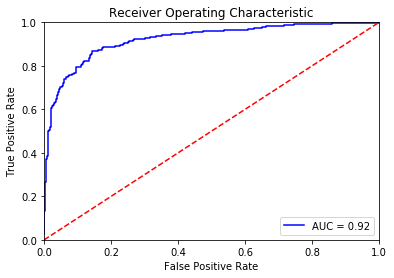

In [10]:
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(test['label'], preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

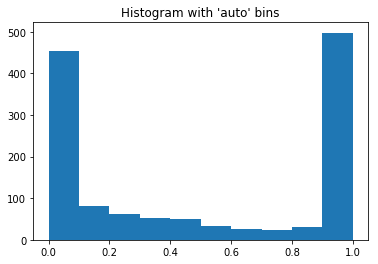

In [11]:
plt.hist(preds, bins=10)  # plt.hist passes it's arguments to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [12]:
# Getting Few Fake News Article in the 0.4 to 0.5 range
test['pred']=preds

almost_real = test.loc[(test['pred'] > 0.0) & (test['pred'] < 0.1) & (test['label'] == 0)]

In [13]:
# Prepare Fake/Real Score sheet 
colnames=vectorizer.get_feature_names()
test_set=pd.DataFrame(data=test_data_features,columns=colnames)
test_set['y_pred_prob']=preds
test_set['y_pred']=predicted

In [14]:
# test_set.to_csv('test_features.csv', sep='\t')
fake_test_total = test_set.loc[(test_set['y_pred'] == 0)].sum().to_frame()
real_test_total = test_set.loc[(test_set['y_pred'] == 1)].sum().to_frame()

# Get real and fake word count across all the news articles
fake_test_total['feature_name'] = fake_test_total.index
fake_test_total.reset_index()
fake_test_total.columns = ['total_count','feature_name']
fake_test_total['real_or_fake']='FAKE'
real_test_total['feature_name'] = real_test_total.index
real_test_total.reset_index()
real_test_total.columns = ['total_count','feature_name']
real_test_total['real_or_fake']='REAL'

combined_word_count = pd.concat([fake_test_total,real_test_total])

In [15]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

def get_plot(results):
    x = results.iloc[:,1].tolist()
    y = results.iloc[:,0].tolist()
    plt.plot(y)
    plt.xticks(range(len(x)), x)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.show()

top_sorted_fake_results = fake_test_total.sort_values(by='total_count', ascending=False).head(75)
btm_sorted_fake_results = fake_test_total.sort_values(by='total_count', ascending=True).head(75)
top_sorted_real_results = real_test_total.sort_values(by='total_count', ascending=False).head(75)
btm_sorted_real_results = real_test_total.sort_values(by='total_count', ascending=True).head(75)



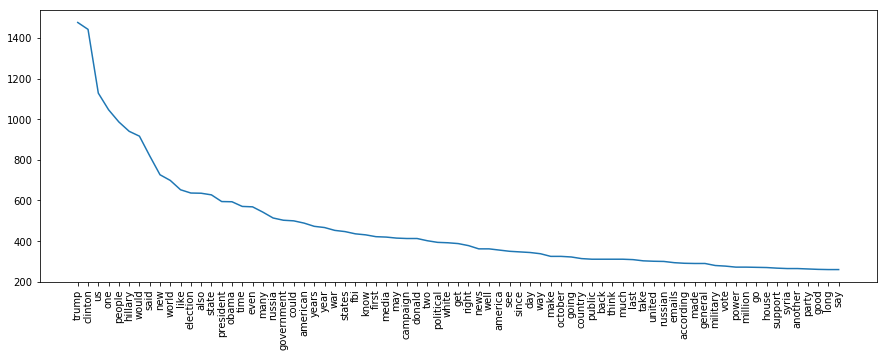

In [16]:
# Get Top Keywords in Fake News
get_plot(top_sorted_fake_results)

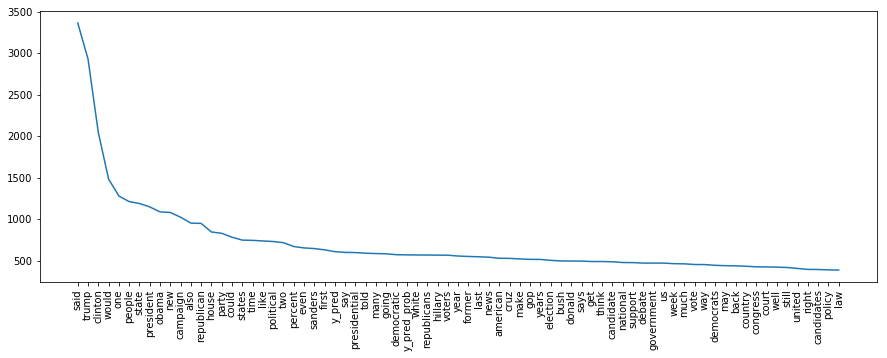

In [17]:
# Get Top Keywords in Real News
get_plot(top_sorted_real_results)

In [18]:
'''
As you can see from the above graphs,  the Top Keywords dont give any hints at stories that 
are real and stories that are not since these keywords occur in both the real and fake keywords
Maybe looking at the bottom keywords migth say a better story
'''

'\nAs you can see from the above graphs,  the Top Keywords dont give any hints at stories that \nare real and stories that are not since these keywords occur in both the real and fake keywords\nMaybe looking at the bottom keywords migth say a better story\n'

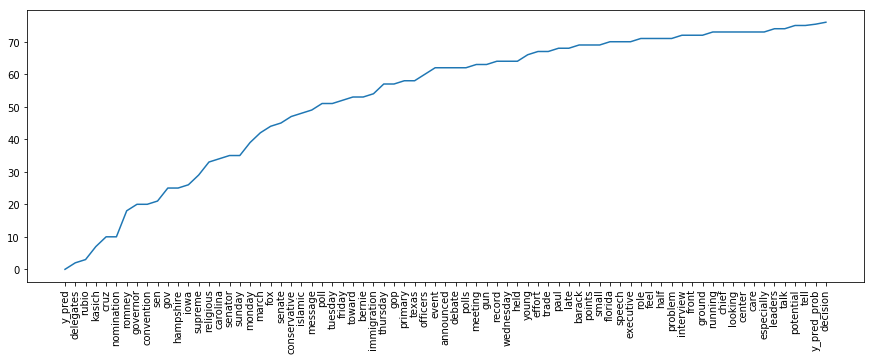

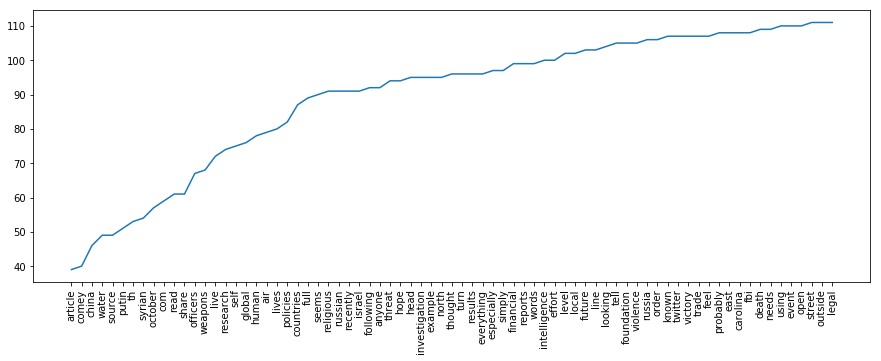

In [19]:
# Get Bottom Keywords in Fake News
get_plot(btm_sorted_fake_results)
get_plot(btm_sorted_real_results)

In [20]:
test.to_csv('test.csv')

In [21]:
# We identified words which are unique and least used in real news  
# Added those words to the fake news making it look real
# We see the before & after altering the fake news. 
# Probability of it being a real news shoots up

def get_prob(sample_text):
    sn = pd.DataFrame([sample_text],columns=['sample_news'])
    sample_data_features = vectorizer.transform(sn['sample_news'])
    sample_data_features = sample_data_features.toarray()
    predicted = lr.predict(sample_data_features)
    probs = lr.predict_proba(sample_data_features)
    print (probs)
    print (predicted)
    
sample_text = 'monday presidential debate hillary clinton asserted alicia machado former miss universe victimized weight donald trump remarks perhaps rightfully given women pause let reflect moment add context allegation come like many young girls era grew watching miss america pageant friends would get together root young woman state pick another favorite make top ten held breath struggled answer interview question discussed answers regarding world peace clapped pianist giggled fiery baton twirler reality tv reality tv knew years later would friends young women went laudable careers law broadcasting women know remain today smart gifted women noble character fast forward today somewhere along way pageants fell favor perhaps second wave feminism perhaps got bored regardless abc television network dropped show coverage due record low ratings cmt picked remains smaller following us done miss america however racy sisters miss usa co owned miss universe time split vying attention unlike miss america pageants make pretense anything beauty pageant talent competition award scholarships fact according bustle com entire reason split miss america yolande belbeze refused photographed newspaper wearing swimsuit one show sponsors catalina swimwear retaliated creating show thus miss usa miss universe course smart talented women chosen participate miss usa miss universe pageants let honest win women participate voluntarily bikini walk front judges well judged participants competing job based bodies good looks worth based almost solely upon things one year represent company asset conventional beauty brains talent beauty quite literally bodies money makers little known fact even u government recognizes arrangement told friends modeled able write taxes anything keep assets looking good things women spend money hair makeup gym memberships even botox write even uncle sam gets joke bodies small businesses suppose deal logically get victim think alicia machado name calling never nice shocker donald trump diplomatic giving criticism irony regardless much hillary clinton wants ms machado poster child misused women fit narrative let honest woman voluntarily puts bikini literally asks people judge based almost solely body mad ms machado paid look perfect live standard asked measured caught criticism maybe also smart kind knows chosen serve miss universe one year point life feel conflicted pageants women love done cwa young women america boasts one pageant winner logical women however pretend alicia machado misused millions women across nation objectified abused victims sexism misogyny let work protect instead inventing new ones penny young nance president ceo concerned women america nation largest women public policy organization author forthcoming book feisty feminine rallying cry conservative women zondervan'
# Additional Key words obtained from frequenct words in real articles
fake_addition = 'candidate law policy united democrats country congress count former american make policy good message supreme'

get_prob(sample_text)
sample_text = fake_addition + sample_text
get_prob(sample_text)

# As you can observe that the News became a Real news from being tagged as a Fake news by just adding few words to the fake story

[[ 0.51991284  0.48008716]]
[0]
[[ 0.25378401  0.74621599]]
[1]
